## Pneumonia_diagnosis
85% 이상의 Accuracy를 가지는 X-RAY 사진 판독 폐렴 진단기를 만들어 봅시다.


## 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

- 패키지(라이브러리) import 

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
tf.random.set_seed(31)
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
import shutil

from glob import glob
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from PIL import Image

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 22

train_dir = ROOT_PATH + "/chest_xray/train/"

test_dir = ROOT_PATH + "/chest_xray/test/"

val_dir = ROOT_PATH +  "/chest_xray/val/"

print(ROOT_PATH)


/home/ssac27/aiffel


## 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
의료영상 이미지가 불균형한 문제를 augmentation를 사용해서 해결해 봅시다.  

그러나 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기에 좌우반전 정도의 간단한 **augmentation**만 사용하겠습니다. 

패키지들을 import 했으니 데이터를 가져오겠습니다.  
우선, 데이터의 갯수를 확인해 봅니다.

In [3]:
train_filenames = tf.io.gfile.glob(str(train_dir + '*/*'))
test_filenames = tf.io.gfile.glob(str(test_dir + '*/*'))
val_filenames = tf.io.gfile.glob(str(val_dir +'*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(train_dir + '*/*'))
filenames.extend(tf.io.gfile.glob(str(val_dir+'*/*')))
filenames.extend(tf.io.gfile.glob(str(test_dir+'*/*')))

# train, val, test dataset으로 분할. train 8, val 1, test 1의 비율로 분할

train_filenames, filenames = train_test_split(filenames, test_size=0.2) # train과 나머지 8:2로 분할
test_filenames, val_filenames = train_test_split(filenames, test_size = 0.5) # 위에서 남은 나머지를 50%로 분할

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4684
586
586


이제 train은 4684, test는 586, val은 586 되었습니다. test_size를 수정하면 갯수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1278
Pneumonia images count in training set: 3406


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.

tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4684
Validating images count: 586


라벨 이름들을 한번 확인해보겠습니다.

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(train_dir + "*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


두 개의 라벨이 있군요. 정상을 의미하는 'NORMAL', 폐렴을 의미하는 'PNEUMONIA' 가 있습니다.

현재 이미지에는 라벨 데이터가 따로 없습니다. 제목에 'NORMAL', 'PNEUMONIA'라고 되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줍니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [12]:
for image, label in train_ds.take(1):  # train_ds에서 1개의 데이터를 가지고 온다. 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


이제 train과 validation 데이터 셋을 만든 것 처럼 test 데이터 셋도 만들어 보겠습니다. 그리고 데이터 갯수도 확인해보겠습니다.

In [13]:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

586


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.  
**prepare_for_training()** 함수는 **shuffle**, **repeat**, **batch**, **prefetch**를 통해 학습 데이터를  효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.  



이미지 리사이즈가 잘 되었고 라벨도 잘 들어가 있는것을 확인했으니 이제 이미지 불균형을 맞춰봅시다.   


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(data_set, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    data_set = data_set.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    # shuffle : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
    data_set = data_set.shuffle(buffer_size=shuffle_buffer_size)
    
    # repeat() : epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 
    #          이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해줍니다.
    data_set = data_set.repeat()

    # batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
    data_set = data_set.batch(BATCH_SIZE)

    # prefetch() : 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안
    #            두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    data_set = data_set.prefetch(buffer_size=AUTOTUNE)

    return data_set

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
augmentation의 결과를 **show_batch()** 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

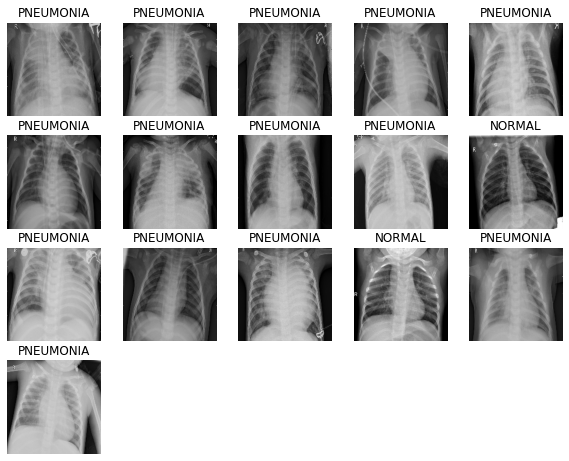

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
Normal = glob(train_dir + "NORMAL/*")
Pneumonia = glob(test_dir + "PNEUMONIA/*")

Display Normal Images


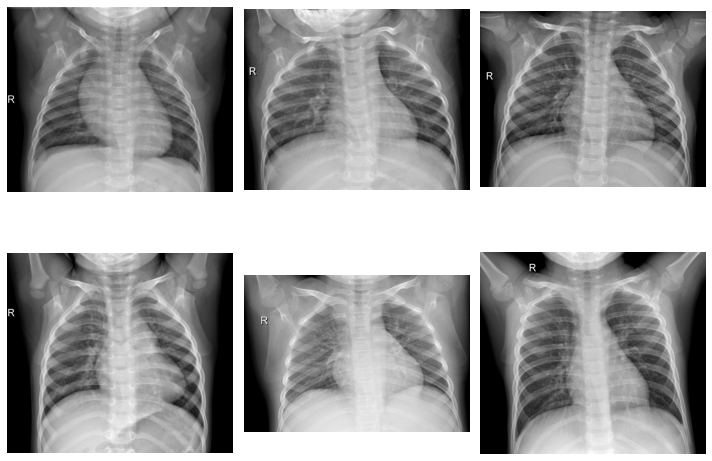

In [17]:
# 6개의 NORMAL 이미지 extract
random_images = [Normal[i] for i in range(9)]

print('Display Normal Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

Display Pneumonia Images


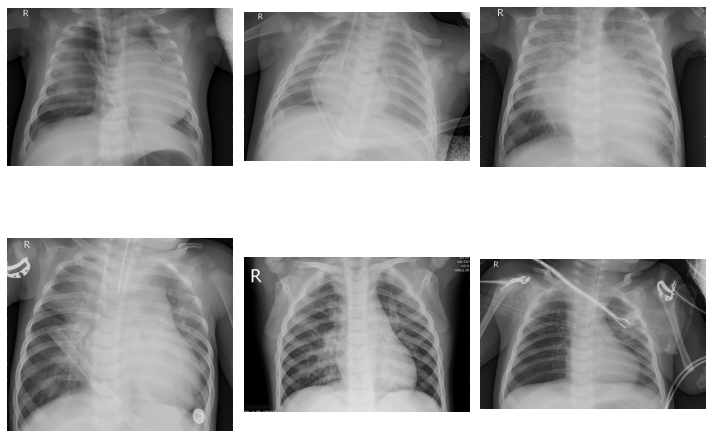

In [18]:
# 6개의 Pneumonia 이미지 extract
random_images = [Pneumonia[i] for i in range(9)]

print('Display Pneumonia Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

## 4. CNN 모델링

우리는 BatchNormalization과 과적합을 방지를 위해 Dropout을 한 모델 안에서 동시에 사용하는 구성을 사용하겠습니다.  

conv_block은 5채널의 위아래로 1채널을 두는 방식을 사용하겠습니다.

dense_block은 dense layer 아래에 BatchNormalization, Dropout의 구조를 사용하겠습니다.


In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 1, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 5, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 1, activation='relu', padding='same'),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

Dense Block은 아래와 같이 만듭니다.

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.4),

        conv_block(256),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었습니다.  한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 imbalance 문제를 해결하기 위해 **Weight balancing**이라는 불리는 기술을 사용하겠습니다. Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.

In [22]:
# (1/정상 사진) *( train의 전체 이미지)  /2.0
## 2개의 대한 가중치를 계산하니 2.0을 나누어 주어서 가중치 크기를 더 줄인다.
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0   

weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.83
Weight for class 1: 0.69


## 6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 **build_model()**을 model에 선언합니다.

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    
    model.compile(
        optimizer='Adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        
    )

Epoch 1/22
292/292 [==============================] - 27s 92ms/step - loss: 0.8425 - accuracy: 0.5043 - precision: 0.7277 - recall: 0.5088 - val_loss: 0.7075 - val_accuracy: 0.2847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/22
292/292 [==============================] - 22s 76ms/step - loss: 0.7699 - accuracy: 0.4944 - precision: 0.7220 - recall: 0.4954 - val_loss: 0.6881 - val_accuracy: 0.7135 - val_precision: 0.7135 - val_recall: 1.0000
Epoch 3/22
292/292 [==============================] - 23s 79ms/step - loss: 0.7317 - accuracy: 0.5032 - precision: 0.7311 - recall: 0.5016 - val_loss: 0.7533 - val_accuracy: 0.2882 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/22
292/292 [==============================] - 23s 78ms/step - loss: 0.7205 - accuracy: 0.4859 - precision: 0.7146 - recall: 0.4873 - val_loss: 0.8051 - val_accuracy: 0.2865 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/22
292/292 [==============================] - 23s 78ms/step - lo

### 결과 확인과 시각화
그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

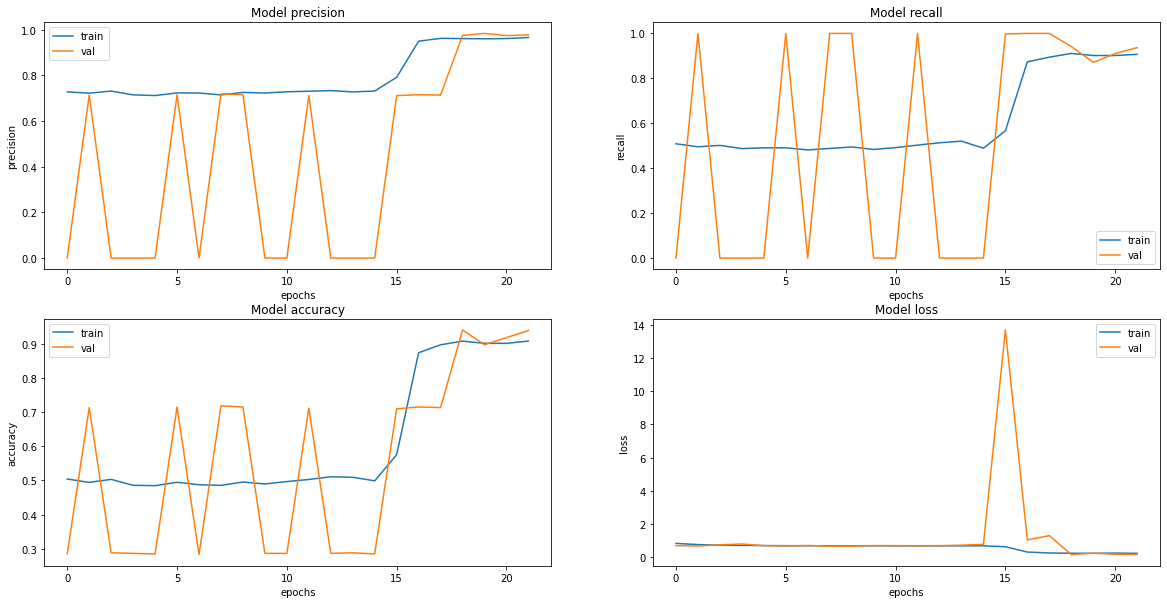

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

그래프를 보면 train, val이 1에 수렴하는 모습을 볼 수 있습니다. 

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)

37/37 [==============================] - 16s 421ms/step - loss: 0.2050 - accuracy: 0.9181 - precision: 0.9854 - recall: 0.9062


accuracy가 0.9181로 높지만 좀 더 높여 보겠습니다. 

### 모델 미세 조정
- 모델의 checkpoint와 early_stopping를 설정해서 모델을 더 조정해 보겠습니다.



- Keras의 콜백 메서드를 사용하여 모델을 조정합니다.  
체크 포인트 콜백은 모델의 최상의 가중치를 저장하므로 다음에 모델을 사용하려고 할 때 모델을 훈련하는 시간을 줄여줍니다. 

In [28]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

### learning rate 스케줄링
학습률이 너무 높으면 모델이 분산됩니다. 학습률이 너무 작으면 모델이 너무 느려집니다. 아래의 지수 학습률 스케줄링 방법을 구현합니다.

In [29]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=100,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
292/292 [==============================] - 22s 75ms/step - loss: 0.4175 - accuracy: 0.8086 - precision: 0.9210 - recall: 0.8061 - val_loss: 0.8627 - val_accuracy: 0.7396 - val_precision: 0.9645 - val_recall: 0.6602 - lr: 0.0100
Epoch 2/100
292/292 [==============================] - 22s 77ms/step - loss: 0.3073 - accuracy: 0.8780 - precision: 0.9549 - recall: 0.8734 - val_loss: 0.3785 - val_accuracy: 0.8802 - val_precision: 0.9885 - val_recall: 0.8415 - lr: 0.0089
Epoch 3/100
292/292 [==============================] - 23s 78ms/step - loss: 0.2813 - accuracy: 0.8908 - precision: 0.9587 - recall: 0.8882 - val_loss: 0.2617 - val_accuracy: 0.9062 - val_precision: 0.9145 - val_recall: 0.9588 - lr: 0.0079
Epoch 4/100
292/292 [==============================] - 22s 75ms/step - loss: 0.2658 - accuracy: 0.9020 - precision: 0.9622 - recall: 0.9005 - val_loss: 0.3263 - val_accuracy: 0.8663 - val_precision: 0.9912 - val_recall: 0.8200 - lr: 0.0071
Epoch 5/100
292/292 [===================

##  7. 결과 확인과 시각화

이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

의료 영상 모델의 특성상 **recall**도 중요하므로 recall의 양상을 중요하게 살펴 봅시다.

**recall** : Normal인 이미지를 Noraml로 예측한 경우

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력 해보겠습니다.

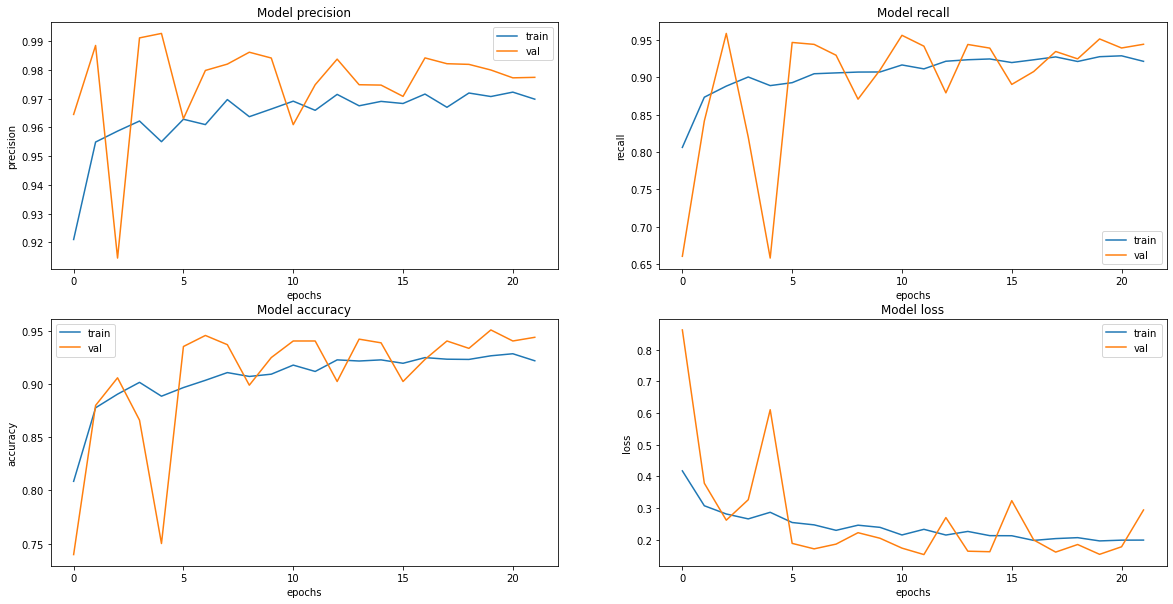

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

그래프를 보면 전체적으로 train, val이 1에 수렴해 가는 모습을 볼 수 있습니다. 

In [32]:
loss, acc, prec, rec = model.evaluate(test_ds)

37/37 [==============================] - 2s 49ms/step - loss: 0.1535 - accuracy: 0.9317 - precision: 0.9811 - recall: 0.9286


체크포인트를 사용하고서 **accuracy**가 0.918에서 0.931로 0.015 증가 **recall** 값도 0.906에서 0.928로 0.022로 증가 했습니다.


## 회고

- 의료 이미지를 가지고 폐렴인지 아니면 정상인지 판별을 진행하면서 의료 분야에 관심이 있었는데 이 프로젝트를 진행하면서 CV가 의료 분야에도 사용을 많이 한다는것을 알게 되었습니다. 



- 기존에 의료 분야로는 그저 시약에 조합이나, 바이러스나 세균등의 구조를 분석해서 효과적인 약을 개발하는 용도로만 생각했는데 이렇게 **Computer Vision**으로 **X-ray**, **CT** 등의 이미지를 분석하는 방식은 생각을 못 했습니다.  
이렇게 프로젝트를 진행하면서 의료 분야에 이런 방식으로 CV가 접목되니 또 다른 방식으로의 접근도 생각이 듭니다.  


- 우선 현미경으로 관측한 적혈구를 가지고 이게 정상 적혈구인지 아니면 비정상 적혈구인지 등을 알 수 있겠다 생각이 들고 또 적혈구만이 아닌 다른 세포들의 모습을 보고 정상 세포인지 아니면 비정상 세포인지 등을 파악할 수 있겠다 생각이 들었습니다.  



- 이 프로젝트를 진행하면서 앞으로 머신러닝이나 딥러닝이나 어떻게 쓰이면 좋을지와 어디에 쓰면 좋을지 등을 좀 더 넓은 시각으로 생각해보는 습관을 가져야겠습니다.  



- Dropout과 BatchNormalization을 같이 사용하는 방식을 권장하지 않는다고 하는데, 이번에 사용해보니 과적합될 가능성이 있는 데이터에 한해서는 같이 사용하는것도 괜찮은것 같습니다.